**Authors:** David Štych, Aleksandra Jamróz

![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)
#### Mount Google Drive, install dependencies and download the database. Since the database will take up to 10 minutes to download, continue reading the next sections.
 

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Create a new folder in your drive and change to that directory as: 
# /content/drive/My_Drive/new_dir_that_you_just_created_for_this_lab
import os
os.chdir('/content/drive/My Drive/lab_dataset/L7-ASR')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torchaudio
import pdb
from torchaudio.datasets import LIBRISPEECH

#Content data is a local folder for the node, this will accelerate the training process, but requires that you download the dataset every time you run the notebook
data_path = '/content/drive/MyDrive/lab_dataset/data'
#If you need persistence, and want to avoid future downloads, you can set a path in google drive (e.g. './data' ). However, be aware that this will make the training process slower


if not os.path.isdir(data_path):
    os.makedirs(data_path)

trainDataset = LIBRISPEECH(data_path, url="train-clean-100", download=True)
testDataset = LIBRISPEECH(data_path, url="test-clean", download=True)

print("done")

done


# LAB SESSION 7
---

# Deep Learning for ASR

### Audio Processing, Video Processing and Computer Vision

### Bachelor in Data Science and Engineering
### Academic Course 2021/2022



1. INTRODUCTION AND OBJECTIVES
2. UTILITY FUNCTIONS
3. THE DATASET
4. EVALUATING A SPEECH RECOGNITION MODEL
5. THE SPEECH RECOGNITION MODEL
6. THE TRAINING AND TESTING CODE


NOTE: you will find sections in this notebook called exercises, which are the ones you are expected to report for evaluation. You will also find questions as comments in the code. Those are for you to think about, but we don't expect those to be handed over to us.

---
## 1. INTRODUCTION AND OBJECTIVES
---
In this lab session, we are going to work with a deep network that performs automatic speech recognition using pytorch. This is, you give the model an audio file containing the voice of a person speaking english, and as the model 
will output a text string containing (hopefully) the words said by that person.

To train such network with need voice audio files along with the text the model is expected to generate, hence, (voice, utterance) pairs. The [LibriSpeech](http://www.openslr.org/12/) dataset contains exactly that kind of data.

The general architecture of the system is inspired on DeepSpeech 2 (by Baidu), and shown in the next illustration

![Intro](https://landen.imgix.net/blog_KKMFzSYvUskeYQpX/assets/BHOBfDVTcGCQKTtp.png)

Before diving into the code, here is a general overview of the complete system:


1.   The audio is loaded and transformed into a spectrogram (we just changed from audio input to image input).
2.   The spectrogram is passed through a CNN that computes visual features for different time-instants. At this point, a time instant is a bunch of columns from the spectrogram image.
3.   The visual features are passed through a linear layer to accomodate the data dimensionality.
4.   The processed visual features of each audio segment (time-instant) are used as a sequence in a recurrent neural network (RNN)
5.   A final linear layer + softmax estimates, for each visual feature, the probability of being each possible letter. For that end, a CTC module and loss are employed to generate and align output sequences and labels. 
6.   Finally, the decoder generates the final text output.




---
## 2. UTILITY FUNCTIONS
---

We need to execute now some utility functions that the rest of the code uses. In this session, there is only this TextTransform class. 


In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')
    
if(__name__ == '__main__'):
        
    text_transform = TextTransform()
    
    texts = ['','A A','HELLO WORLD']
    for t in texts:
        tti = text_transform.text_to_int(t.lower())
        print('Text: \n{}'.format(t))
        print("Is encoded as:")
        print(tti, "\n")

Text: 

Is encoded as:
[] 

Text: 
A A
Is encoded as:
[2, 1, 2] 

Text: 
HELLO WORLD
Is encoded as:
[9, 6, 13, 13, 16, 1, 24, 16, 19, 13, 5] 



---
## 3. THE DATASET
---

In pytorch, we use the [Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) class to read samples from disk and prepare them to be inputs of the model.

Read the code and try to understand the different methods. Then, awnser the proposed questions in EXERCISE 1 


/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Visualize sample 1


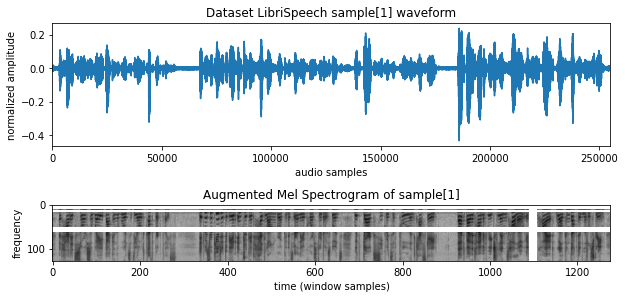



Original transcription and generated labels

THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF THE OLD CUTHBERT PLACE IT WAS REPUTED TO BE AN INTRICATE HEADLONG BROOK IN ITS EARLIER COURSE THROUGH THOSE WOODS WITH DARK SECRETS OF POOL AND CASCADE BUT BY THE TIME IT REACHED LYNDE'S HOLLOW IT WAS A QUIET WELL CONDUCTED LITTLE STREAM
tensor([21.,  9.,  2., 21.,  1.,  9.,  2.,  5.,  1., 10., 21., 20.,  1., 20.,
        16., 22., 19.,  4.,  6.,  1.,  2., 24.,  2., 26.,  1.,  3.,  2.,  4.,
        12.,  1., 10., 15.,  1., 21.,  9.,  6.,  1., 24., 16., 16.,  5., 20.,
         1., 16.,  7.,  1., 21.,  9.,  6.,  1., 16., 13.,  5.,  1.,  4., 22.,
        21.,  9.,  3.,  6., 19., 21.,  1., 17., 13.,  2.,  4.,  6.,  1., 10.,
        21.,  1., 24.,  2., 20.,  1., 19.,  6., 17., 22., 21.,  6.,  5.,  1.,
        21., 16.,  1.,  3.,  6.,  1.,  2., 15.,  1., 10., 15., 21., 19., 10.,
         4.,  2., 21.,  6.,  1.,  9.,  6.,  2.,  5., 13., 16., 15.,  8.,  1.,
         3., 19., 16., 16., 12.,  1., 10., 15

In [ ]:
import os

import torch
import torch.nn as nn
import torchaudio
from torchaudio.datasets import LIBRISPEECH
import numpy as np
import numpy.random 
import matplotlib.pyplot as plt

np.random.seed(42)

class LibriSpeech(LIBRISPEECH):
    
    """
    A dataset class derived from the torchaudio.datasets.LIBRISPEECH class.
    The intention is to zip in this class all code related to loading the
    training and test input samples for the model.
    
    Each sample in the dataset has 6 entries:
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
    """
    
    def __init__(self, path, mode, n_feats, download=True, numData=None):
        
        url = "train-clean-100" if mode == 'train' else "test-clean"

        #super(LibriSpeech, self).__init__( data_path, url=url, download=download)
        super(LibriSpeech, self).__init__( path, url=url, download=download)
        
        
        if not os.path.isdir(path):
            os.makedirs(path)
        
        if( mode == "train" ):
            self.audioTransforms = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_feats),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
            torchaudio.transforms.TimeMasking(time_mask_param=100) )
            
        elif( mode == "test" ):
            self.audioTransforms = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_feats))
            
        else:
            raise RuntimeError("Unsupported mode: must be train or test")
        
        
                      
        if numData:
          self.numData=numData
          self.idx=np.random.choice(LIBRISPEECH.__len__(self), size=numData,replace=True)
        else:
          self.numData=LIBRISPEECH.__len__(self)
          self.idx=np.arange(self.numData)

        self.text_transform = TextTransform()
        return
    
    def __len__(self):
      return self.numData;

    def __getitem__(self, n, returnRaw=False): 
        
        """
        This function is called to retrieve each dataset sample. First, it
        recovers the raw sample from the original torchaudio LIBRISPEECH 
        dataset (origSample), that contains the waveform and utterance transcript 
        
            origSample = (tensor[1,numSamples], str)
            
            then, it applies the audio transformations defined on this class 
        constructor (that turns the [1,numSamples] audio signal into a [M,N] 
        spectogram image) and encode the string utterance into a list of integers. 
        
            spec = tensor[T, mel_coeffs]
            label = list[len(utterance)]

            mel_coeffs is the number of MEL coefficients used to compute the 
        spectogram (the frequency dimension) and T is the resulting length of 
        the spectogram (the time dimension) (check MelSpectrogram to understand
        the relation between the original audio duration and the resulting 
        spectogram length)
        
        """
        origSample = LIBRISPEECH.__getitem__(self,self.idx[n])
        (waveform, _, utterance, _, _, _) = origSample
        
        spec = self.audioTransforms(waveform).squeeze(0).transpose(0, 1)
        label = torch.Tensor(self.text_transform.text_to_int(utterance.lower()))
        
        if not returnRaw:
            return (spec, label)
        else:
            return (waveform, spec, utterance, label)
    
    
    def collate(self, data):
    
        """
        This function is used by the DataLoaders to build the data batches
        that are inputs of the speech recognition model.
        
        It receives as input a list of N tuples (N = batch size). Each tuple is
        generated by this class method __getitem__(), like this:
            
            data = [ (spec1,label1), (spec2,label2), ...]
        
        The function stacks all the spectograms and labels accounting
        for the different lengths by means of a zero padding scheme.
        The output is:
            
            spectrograms = [N, 1, mel_coeffs, maxT]
            labels       = [N, maxCharacters]
            inputLengths = half the original spec lengths before the padding
            labelLengths = original label lengths before the padding
        
        """
        
        spectrograms = []
        labels = []
        specLengths = []
        labelLengths = []
        
        for (spec, label) in data:
            
            spectrograms.append(spec)
            labels.append(label)
            
            specLengths.append(spec.shape[0]//2)
            labelLengths.append(len(label))
    
        spectrograms = nn.utils.rnn.pad_sequence(
            spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
        return spectrograms, labels, specLengths, labelLengths
        

if( __name__ == '__main__' ):
    
    path = data_path#"./data"
    mode = "train"
    n_feats = 128
    download = True
    
    trainDataset = LibriSpeech(path, mode, n_feats, download=download)
    
    # get a sample and plot the original audio and transcription with their
    # corresponding augmented spectrogram and labels transformations
    
    i = 1
    print("Visualize sample {}".format(i))
    
    samplei = trainDataset.__getitem__(i,returnRaw=True)
    (waveform, spec, utterance, label) = samplei
    
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(waveform.t().numpy())
    plt.xlim([0, waveform.shape[1]])
    plt.xlabel("audio samples")
    plt.ylabel("normalized amplitude")
    plt.title("Dataset LibriSpeech sample[{}] waveform".format(i))
    plt.subplot(2,1,2)
    plt.imshow(spec.T.log2().detach().numpy(), cmap='gray_r')
    plt.xlabel("time (window samples)")
    plt.ylabel("frequency")
    plt.title("Augmented Mel Spectrogram of sample[{}]".format(i))
    plt.show()
    
    print("\n\nOriginal transcription and generated labels\n")
    print(utterance)
    print(label)
    
    # lets build a batch of two samples to check the dimensions of the network
    # inputs
    print("\n\nBuild a batch of samples and check the dimensions")
    sample0 = trainDataset[0]
    sample1 = trainDataset[1]
    data = (sample0, sample1)
    batch = trainDataset.collate(data)
    
    spectrograms, labels, specLengths, labelLengths = batch
    print("spectroams shape")
    print(spectrograms.shape)
    print("labels shape")
    print(labels.shape)
    

We next hear the speech of the two samples. The next cell only works in local mode and not in Google Colab.

In [ ]:
from pydub import AudioSegment
from pydub.playback import play
import numpy as np

#Function that plays a numpy array of samples
def playSample(samples):
    #Convert to 16bit-unsigned integer
    samplesb = np.int16(samples * 2 ** 15)

    audio_segment = AudioSegment(
        samplesb.tobytes(), 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )

    play(audio_segment)
if( __name__ == '__main__' ):    
    #Play sample 0
    playSample(trainDataset.__getitem__(0,returnRaw=True)[0].numpy())
    #Play sample 1
    playSample(trainDataset.__getitem__(1,returnRaw=True)[0].numpy())
    

---
### [EXERCISE 1]
---

The LibriSpeech class is responsible of preparing the input data  for
the speech recognition models. It must read the audio files with their
corresponding transcriptions from disk, and apply all the necessary 
transformations (depending on whether the data is for train or test)

In particular, note that this class computes spectrograms (which are two
dimensional signals that usually are visualized as images).

Asnwer the following questions in the cell above:

1.   Are we losing any information from the original audio signals by
      transforming them into MEL spectrograms and giving the model just that?
      In other words, can you recover the original audio signal from the spectrogram alone?
2.   If deep learning is about models learning what features to extract
      from the raw data, why aren't we giving the network the raw
      audio signals?
3.   Can you explain the data augmentation mechanism implemented in this 
      class? (FrequencyMasking and TimeMasking functions), what would you listen by playing the augmented samples in comparison with the original ones?

      HINT: Try to find information such as [this](https://arxiv.org/abs/1706.09559) analyzing the first two questions of this exercise.


### [ANSWER EX 1]



1.   We are losing information about the phase of the signals. We can only approximate original audio from MEL using, for example, the Griffin-Lim algorithm.
2.   By conversion to the frequency domain, we can express each component and compress the data - lowering the dimensionality of the data and improving the model performance. 

  Another advantage is the simplification of some algorithms. For example, convolution becomes simple multiplication. 

3.   -FrequencyMasking applies a mask to some frequencies and mutes them.
    
    The audio would be distorted and would sound different. Similar to if we muted some part of the frequency in an equalizer in a music player.
    
    -TimeMasking does the same thing but along the time axis (mutes all the frequencies for some time).

  The audio would be muted entirely for some time.

---
## 4. EVALUATING A SPEECH RECOGNITION MODEL
---

In image classification it is common to have a single integer label for each test image. Thus, metrics such as accuracy or confusion matrices are common for evaluating those systems. 

However, in a speech recognition problem we have two sentences with potentially different lengths:

1.   The ground truth one:  containing the actual words that were spoken
2.   The model prediction:  containing the transcription of our model outputs

How do we measure how well the sentences produced by the model fit the ground truth?. Two common metrics are the Character and Word Error Rates (CER, WER). The formulas and explanations for computing them are in the next code cell as comments inside the functions. In the main section of the next cell there are also some examples to help you understand the metrics.

Execute the cell, play with the samples and try to answer the questions in excersice 2.






In [ ]:
import numpy as np

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein distance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)
    
    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))
    
    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer


if( __name__ == '__main__' ):
    
    
    refs = ['HELLO', 'HELLO', 'HELLO WORLD', 'SUP']
    hyps = ['HELLO', 'HELLA', 'HELLO WORLL', 'YOUR MODEL OUTPUTS TOO MANY WORDS']
    
    for ref, hyp in zip(refs,hyps):
        
        print('Real text (ground truth labels)): {}'.format(ref))
        print('Predicted text (Model output)): {}'.format(hyp))
        print('CER rate: {:.2f}'.format(cer(ref, hyp)) )
        print('WER rate: {:.2f}\n'.format(wer(ref, hyp)) )
    
    
    
    
    

Real text (ground truth labels)): HELLO
Predicted text (Model output)): HELLO
CER rate: 0.00
WER rate: 0.00

Real text (ground truth labels)): HELLO
Predicted text (Model output)): HELLA
CER rate: 0.20
WER rate: 1.00

Real text (ground truth labels)): HELLO WORLD
Predicted text (Model output)): HELLO WORLL
CER rate: 0.09
WER rate: 0.50

Real text (ground truth labels)): SUP
Predicted text (Model output)): YOUR MODEL OUTPUTS TOO MANY WORDS
CER rate: 10.33
WER rate: 6.00



### [EXERCISE 2]

- Describe how CER and WER are computed based on the results of the examples executed below (you can use any other illustrative example that you find appropriate).

- In your opinion, which metric is more suitable to assess the capability of the ASR system? 


### [ANSWER EX 2]



*   CER is basically the percentage of incorrect letters = the number of mistakes divided by the length of the ground truth text.

  "HELLO"-> no errors -> 0/5 -> 0.0

  "HELLA" -> 1 wrong letter -> 1/5 -> 0.2
  
  "HELLO WORLL" -> 1 wrong letter -> 1/11 -> 0.091

*  WER is the number of wrong words divided by the total number of words.

  "HELLO" -> no errors -> 0/1 -> 0.0

  "HELLA" -> 1 word wrong -> 1/1 -> 1.0

  "HELLO WORLL" -> 1 word wrong -> 1/2 -> 0.5



---



*   In our opinion, CER is a better metric. Because WER provides no insight into the mistakes. Therefore, it is not possible to identify the primary error sources.

  Also, for speech recognition, a "close enough" might still be easily understandable for a human. However, with WER, it is not accepted.




---
## 4. THE SPEECH RECOGNITION MODEL
---

The next code cell contains the speech recognition model class: SpeechRecognitionModel. The following code does not exactly implement the model depicted in the figure in section 1 but a simplified version with a vainilla RNN. 

Take a look at the main at the end of the code cell and answer the questions in excercise 3.






In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLayerNorm(nn.Module):
    """
    This class is a convenience to do the transposition of the tensor, since
    we want to normalize the features and not the time dimensions.
    
    This is similar to a batchnorm layer but you apply it before the conv layers
    not after (pretty much the same idea with minor modifications). 
    """
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """
    This is basically a block of convolutional residual network. Since the
    input and output has the same dimensions (as long as the stride=1)
    you can stack as many as you want.
    
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)   
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
    
class SimpleRNN(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(SimpleRNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.RNN(x)
        x = self.dropout(x)
        return x

class SimpleGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first,bidirectional=False):
        super(SimpleGRU, self).__init__()

        self.GRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=bidirectional)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.GRU(x)
        x = self.dropout(x)
        return x

    



class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1,useGRU=False,bidirectionalRNN=False):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//stride
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        #Linear
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)

        #RNN
        if useGRU==False:
          self.recursive_layers = nn.Sequential(*[
              SimpleRNN(rnn_dim=rnn_dim,
                               hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
              for i in range(n_rnn_layers)])
        else:
          self.recursive_layers = nn.Sequential(*[
              SimpleGRU(rnn_dim=rnn_dim if (i==0 or not bidirectionalRNN) else rnn_dim*2,
                               hidden_size=rnn_dim, dropout=dropout, batch_first=i==0, bidirectional=bidirectionalRNN)
              for i in range(n_rnn_layers)
          ])
        if bidirectionalRNN:
            output_channels=rnn_dim*2
        else:
            output_channels=rnn_dim
        #Final Classifier with stack of linear layers
        self.classifier = nn.Sequential(
            nn.Linear(output_channels, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.recursive_layers(x)
        x = self.classifier(x)
        return x
    
    
if( __name__ == '__main__' ):
    print('entra')
    
    # these are the options of the model
    hparams = {
        "n_cnn_layers": 1,
        "n_rnn_layers": 2,
        "rnn_dim": 256,
        "n_class": 29,
        "n_feats": 128, # number of mel coeffs in the spectrogram
        "stride":2,
        "dropout": 0.1,
        "useGru": True,
        "bidirectional": True,
    }
    
    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout'],
        hparams['useGru'],hparams['bidirectional']
        )
    
    
    # Lets go over each step in the forward method of the SpeechRecognitionModel
    # to understand the inputs and outputs of each submodule inside it
    
    # generate a batch with a single image to use as model input (just noise
    # with the proper dimensions)
    x = torch.randn(1, 1, 128, 1249)
    
    # the model first uses a 32 filter conv layer with a stride of 2 which halves
    # the time and frequency dimensions of the input spectrogram
    x = model.cnn(x) # x.shape = [1, 32, 64, 625]
    
    # then it goes through the residual backbone preserving its shape
    x = model.rescnn_layers(x) # x.shape = [1, 32, 64, 625]
    
    # now the x volume its reshaped to join all features
    sizes = x.size()
    x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
    x = x.transpose(1, 2) # (batch, time, feature) with x.shape = [1, 625, 2048]
    
    # at this point we have 625 time instants, each represented by a 2048 feature vector
    # we compress the 2048 feature vectors into 512 ones using a fully connected
    x = model.fully_connected(x) # x.shape = [1, 625, 512] (numImage,timeInstant,Feature)
    
    # now, we use the recurrent layer that will give us for each of the 625
    # time instants, a feature vector of dimension 512 
    x = model.recursive_layers(x) # x.shape = [1, 625, 512]
    
    # finally, we need a classifier to take every of the 625 feature vectors (of
    # dimensionality 512) coming out of the rnn and give a distribution of 
    # scores over each possible letter
    x = model.classifier(x) # x.shape = [1, 625, 29]
    
    # to get the final text out of x, you need to implement some strategy
    # such as the one in the greedyDecoder function provided.
    print(x.shape)
    
    
    

entra
torch.Size([1, 625, 29])


---
### [EXERCISE 3]
---

In the previous cell, define a new class `SimpleGRU` and integrate it into the SpeechRecognitionModel class, by filling the blank spaces where code is required.

This class should be inspired in the SimpleRNN class, but substituting the vainilla RNN by a GRU layer with the possibility of being bidirectional. The constructor method should have the following interface:

`__init__(self, rnn_dim, hidden_size, dropout, batch_first,bidirectional=False)`

In addition, in order to get a class compatible with the pretrained weights provided in the practice, the object implementing the GRU layer should be called: `self.GRU`

HINT for integration: Bidirectional recursive layers are internally implemented in pytorch as two
    individual layers (but sharing weights), each of them looking at the input data in reverse order
    from each other. Both individual outputs are then concatenated into a 
    final tensor. Thus, the dimension of the output gets doubled with 
    respect to a non bidirectional GRU. This will cause the first fc layer in 
    the classifier to fail if not taken into account. Change the fc layer that receives the RNN 
    output to expect rnn_dim*2 as input dimension when using 
    bidirectional=True option.
    



---
## 4. TRAINING AND TESTING THE ASR MODEL
---

### Training and test methods
The next code cell contains all the necessary to train and test the speech recognition model. Check that we are using the CTC loss to train our network.


In [ ]:
import os 

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import time

text_transform = TextTransform()


def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets


class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    print('Train Epoch: {} lr = {}'.format(epoch, scheduler.get_lr()[0]))

    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{:04}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))
                
           


def test(model, device, test_loader):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []

    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            
            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))
    print('\n\nEXAMPLE')
    print('GT:')
    print(decoded_targets[-1])
    print("\nNetwork output:")
    print(decoded_preds[-1])
    return


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#We define the loss function to be used for training and evaluation
criterion = nn.CTCLoss(blank=28).to(device)

### [EXERCISE 4]:


Describe why the input parameter (blank=28) means when initializating the CTC Loss. Explain the utility of this element and why the value is 28. Explain how CTC would discriminate between these two expressions: "to deal", "too deal". You can support your answer providing examples of system outputs that will lead to each expression.

### [ANSWER EX 4]

A Blank label is very useful. We use it to deal with situations when some part of the audio does not produce a character.
Value 28 is because we have 28 characters defined in the TextTransform class. Labels are indexed from 0, so the first empty index is 28.


For "to deal" a blank label 28 would be produced for the second "o" character. Therefore, it would not be appended to the transcript.

### Training Models

The following code defines model and training params and calls the training function to learn the weights of the model. 

**IMPORTANT: Avoid executing this cell if you plan use pre-trained networks provided with the practice.**

In [ ]:
#COMMENT OUT TO AVOID ACCIDENTAL EXECUTION
'''
if( __name__ == '__main__'):

    """
    Use this code to train a model with a particular group of settings. Before
    changing any values make sure you understand what they are there for.
               
    You can try to vastly improve the CER,WER by using a predictive dictionarly
    and fix miss-spellings in the model outputs.
    """    

    modelParams = {
        "n_cnn_layers": 2,
        "n_rnn_layers": 2,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.0,
        "useGru": True,
        "bidirectional": True,
    }
    
    
    trainingParams = {
        "learning_rate": 5e-4,
        "batch_size": 10,
        "epochs": 20,
        "db_path": data_path ,
        "weights_path": data_path + "/weights_bigru"
    }
    
    torch.manual_seed(7)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    
    #Subsample the training dataset and limit the number of utterances to 10000 (,numData=10000)
    train_dataset = LibriSpeech(trainingParams['db_path'], "train", modelParams['n_feats'])

    kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=trainingParams['batch_size'],
                                shuffle=True,
                                collate_fn= train_dataset.collate,
                                **kwargs) 

    model = SpeechRecognitionModel(
        modelParams['n_cnn_layers'], modelParams['n_rnn_layers'], 
        modelParams['rnn_dim'], modelParams['n_class'], modelParams['n_feats'], 
        modelParams['stride'], modelParams['dropout'],
        modelParams['useGru'],modelParams['bidirectional']
        ).to(device)
    
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    
    optimizer = optim.AdamW(model.parameters(), trainingParams['learning_rate'])
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=trainingParams['learning_rate'], 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=trainingParams['epochs'],
                                            anneal_strategy='linear')
    spath = trainingParams['weights_path']
    
    if not os.path.isdir(spath):
            os.makedirs(spath)
    
    initEpoch=1;
    iter_meter = IterMeter()
    for epoch in range(initEpoch, trainingParams['epochs'] + 1):
        t = time.time()
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
        if epoch%5==0:
            test(model, device, test_loader)
            torch.save(model.state_dict(), spath + '/model_epoch_{}.tar'.format(epoch))
        print('elapsed time {:.2f} minutes'.format((time.time() - t)/60.0))
        '''

### Testing Models

The training process to learn the optimal parameters of an ASR model is slow and may take several hours. Hence, we are providing you with 3 models that can be directly tested as long as the previous required code is correct. If you do not have time to train your own models, you can ommit the previous cell and directly jump the next one. 

In [ ]:
#This cell is to load and evaluate a model that has been previously trained and saved to disk

def eval_model(modelParams,model_name):
  print(modelParams)
  testParams = {
          "batch_size": 32,
          "db_path": data_path ,
          "weights_path": data_path + "/weights"
      }

  spath = testParams['weights_path']
      
  torch.manual_seed(7)
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)
      
  test_dataset =  LibriSpeech(testParams['db_path'], "test", modelParams['n_feats'])

  kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
  test_loader = data.DataLoader(dataset=test_dataset,
                                  batch_size=testParams['batch_size'],
                                  shuffle=False,
                                  collate_fn= test_dataset.collate,
                                  **kwargs)
      
  model = SpeechRecognitionModel(
          modelParams['n_cnn_layers'],
          modelParams['n_rnn_layers'], 
          modelParams['rnn_dim'],
          modelParams['n_class'],
          modelParams['n_feats'], 
          modelParams['stride'],
          modelParams['dropout'],
          modelParams['useGru'],
          modelParams['bidirectional']
          ).to(device)

  print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

  #Loading the model
  model_path=spath + '/' +model_name
  if os.path.exists(model_path):
      print('Loading pre-trained network from {}'.format(model_path))
      model.load_state_dict(torch.load(model_path),strict=True)

  test(model, device, test_loader)


if( __name__ == '__main__'):
  
  print("INFO: The original ASR model with the vanilla RNN")
  #VANILLA PARAMS
  modelParams = {
          "n_cnn_layers": 2,
          "n_rnn_layers": 2,
          "rnn_dim": 512,
          "n_class": 29,
          "n_feats": 128,
          "stride":2,
          "dropout": 0.0,
          "useGru": False,
          "bidirectional": False,
      }
  eval_model(modelParams,'model_rnn.tar')
  print()
  print()
  print()
  
  print("INFO: The ASR model, but substituting the vainilla RNN by a GRU layer")
  #GRU
  modelParams = {
          "n_cnn_layers": 2,
          "n_rnn_layers": 2,
          "rnn_dim": 512,
          "n_class": 29,
          "n_feats": 128,
          "stride":2,
          "dropout": 0.0,
          "useGru": True,
          "bidirectional": False,
      }
  eval_model(modelParams,'model_gru.tar')
  print()
  print()
  print()
 
  print("INFO: The ASR model, but substituting the vainilla RNN by a bidirectional GRU layer")
  #BIDIRECTIONAL GRU
  modelParams = {
          "n_cnn_layers": 2,
          "n_rnn_layers": 2,
          "rnn_dim": 512,
          "n_class": 29,
          "n_feats": 128,
          "stride":2,
          "dropout": 0.0,
          "useGru": True,
          "bidirectional": True,
      }
  eval_model(modelParams,'model_bigru.tar')
  print()
  print()
  print()

INFO: The original ASR model with the vanilla RNN
{'n_cnn_layers': 2, 'n_rnn_layers': 2, 'rnn_dim': 512, 'n_class': 29, 'n_feats': 128, 'stride': 2, 'dropout': 0.0, 'useGru': False, 'bidirectional': False}
cuda
Num Model Parameters 2417117
Loading pre-trained network from /content/drive/MyDrive/lab_dataset/data/weights/model_rnn.tar

evaluating...
Test set: Average loss: 0.7815, Average CER: 0.239138 Average WER: 0.6775



EXAMPLE
GT:
i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:
i  leve the with a love i seened to the with my lost sans i love be with the breh smiles the rs of al minalling and if do chus i show bet love the better after dath



INFO: The ASR model, but substituting the vainilla RNN by a GRU layer
{'n_cnn_layers': 2, 'n_rnn_layers': 2, 'rnn_dim': 512, 'n_class': 29, 'n_feats': 128, 'stride': 2, 'dropout': 0.0, 'useGru': True,

### [EXERCISE 5]

Evaluate the ASR considering 3 options:
- a) The original ASR model with the vainilla RNN
- b) The ASR model, but substituting the vainilla RNN by a GRU layer
- c) The ASR model, but substituting the vainilla RNN by a bidirectional GRU layer

Compare the results in terms of Average CER, WER and Loss, and include the GT and output senteces provided by the three options. Include a discussion about the results explaining why some options are better than others.

### [ANSWER EX. 5]

Let's rewrite the output first in a nicer form, comparision at the bottom of this block: 
---



**SIMPLE RNN**

Test set: Average loss: 0.7815, Average CER: 0.239138 Average WER: 0.6775



GT:

i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:

i  leve the with a love i seened to the with my lost sans i love be with the breh smiles the rs of al minalling and if do chus i show bet love the better after dath

---
**SIMPLE GRU**

Test set: Average loss: 0.6234, Average CER: 0.211478 Average WER: 0.5855

EXAMPLE

GT:

i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:

i reve the with a love i seemed to lhose with my lost sans i loved the with the braath smiles he re of al mital ife and if gad ches i shal but love the better after deth

---
**BIDIRECTIONAL GRU**

Test set: Average loss: 0.4745, Average CER: 0.138056 Average WER: 0.4204

EXAMPLE

GT:

i love thee with a love i seemed to lose with my lost saints i love thee with the breath smiles tears of all my life and if god choose i shall but love thee better after death

Network output:

i love the with alove i seemed to lo with my lost sains i love the with the breath smil ter of all my life and if god chos i show but love the better after dath

---
---
# **Conslusion**

We see that substituting the vanilla RNN with a GRU layer decreased average loss, average CER, and WER.

Bidirectional GRU achieved an even better result. 

<br>

We would expect this, as RNN suffers from a vanishing gradient problem. Long-term dependencies are causing the gradient to vanish or possibly explode, leading to a difficult learning process. The neural network will improve very slowly or not at all.
Gated cells control what information passes through temporal instants, and it learns to forget.

Bidirectional GRU uses gates for both forward and backward passes. They are providing even more control over what information is passed through.

<br>

Just by looking at the text generated by the network, we can clearly conclude that bidirectional GRU performed the best out of the three. 




---

### [EVALUATION]

Submit this notebook (executed) with your results to the questions by December 19th.